<h1 align="center">☁️ - Cloudy regions segmentation 👨‍💻🔬</h1>

<h2 align="center">Segmentation - pretrained UNet in Pytorch</h2>
<p align="center">
   Thomas Bury, Afonso Alves, Daniel Staudegger<br>
</p>

## Introduction

There are several great notebooks to build on. For educational purposes, a nice way to learn about image segmentation is to use a [kernel starting from scratch](https://www.kaggle.com/code/dhananjay3/image-segmentation-from-scratch-in-pytorch), understand the architecture and then improve by borrowing other elements from other NBs.
Another pitfall to avoid while learning is to use high-level frameworks, convenient for prototyping but not for learning, as they may hide all the details

## Why instance segmentation?
Many deep network architectures are dedicated to classification. However, when localization is also required, we need a pixel-to-pixel identification and a label prediction. Here is the qualitative difference with other methods

![inst_seg](https://i.stack.imgur.com/MEB9F.png)

## Features of this NB
* Using the Unet Architecture
* Deterministic behaviour for reproducibility
* K-fold cross-validation 
* Implement the loss function for clarity, as done in the python package [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch)
* Investigation of the training process
* Processing output (removing the mask that occurs on the black part of the input image)
* Drawing convex hull before optimizing thresholds

## Unet architecture

U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations. 

The architecture consists of a contracting path to capture
context and a symmetric expanding path that enables precise localization. Such a network outperforms the prior best method (a sliding-window
convolutional network) on medical images. One important feature in the UNet architecture is that in the upsampling part there is also a large number of feature channels, which allow the network to propagate context information to higher resolution layers. As a consequence, the expansive path is more or less symmetric to the contracting path, and yields a u-shaped architecture (hence the name).

 * The contracting path follows the scheme `conv_layer1 -> conv_layer2 -> max_pooling -> dropout(optional)`, meaning feature extraction, downsampling (feature selection/dim reduction) and regularization (dropout).
 * The bottom part is only convulotional steps, feature extraction
 * The expansive path follows the scheme `conv_2d_transpose -> concatenate -> conv_layer1 -> conv_layer2` Transposed convolution is an upsampling method that expands the size of images (set the value of a pixel from the kernel to n pixels of the target array). See [the visual explanation](https://naokishibuya.medium.com/up-sampling-with-transposed-convolution-9ae4f2df52d0).

Details in a [short video](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) made by the authors of [the original paper](https://arxiv.org/pdf/1505.04597.pdf)

![Unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

### **references**
1. https://www.kaggle.com/code/dhananjay3/image-segmentation-from-scratch-in-pytorch
2. https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
3. https://www.kaggle.com/ryches/turbo-charging-andrew-s-pytorch
4. https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/losses.py
5. https://github.com/milesial/Pytorch-UNet
6. https://www.kaggle.com/ratthachat/cloud-convexhull-polygon-postprocessing-no-gpu
7. https://github.com/qubvel/segmentation_models.pytorch
8. https://github.com/albumentations-team/albumentations

In [1]:
# !pip uninstall pyreidolia

In [2]:
# !pip install -U git+https://github.com/ThomasBury/pyreidolia

# Imports

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
import segmentation_models_pytorch as smp
# from albumentations import torch as AT
from zipfile import ZipFile
import os
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import yaml
from pprint import pprint

# Custom package for the project, save all the functions into appropriate sub-packages
from pyreidolia.plot import (set_my_plt_style, 
                             plot_cloud, 
                             plot_rnd_cloud, 
                             draw_label_only, 
                             visualize_with_raw)
from pyreidolia.mask import (bounding_box, 
                             rle_to_mask, 
                             get_binary_mask_sum, 
                             mask_to_rle)
from pyreidolia.img import get_resolution_sharpness
from pyreidolia.processing import resize, draw_convex_hull, post_process

from pyreidolia.unet import UNet
from pyreidolia.optim import RAdam
from pyreidolia.io import get_img
from pyreidolia.segmentation import (seed_everything, 
                                     to_tensor, 
                                     CloudDataset, 
                                     get_training_augmentation, 
                                     get_validation_augmentation, 
                                     dice_no_threshold, 
                                     dice, 
                                     BCEDiceLoss)
from pyreidolia.torchloss import DiceBCELoss

set_my_plt_style()

/usr/local/lib/python3.7/dist-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [4]:
import scicomap as sc
import matplotlib as mpl
sc_map = sc.ScicoSequential(cmap='tropical')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("sc_tropical", sc_cmap)

In [5]:
# with ZipFile('/content/test_images_525.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

In [6]:
# from google.colab import files
# uploaded = files.upload()

In [7]:
# from google.colab import drive
# drive.mount('/content/drive') #, force_remount=True)

In [8]:
# doc_path = "/content/drive/MyDrive/pyreidolia/train.csv"
# doc_clean_path = "/content/drive/MyDrive/pyreidolia/train_info_clean.csv"
# submission_path = "/content/drive/MyDrive/pyreidolia/sample_submission.csv"
# folder_path = "/content/drive/MyDrive/pyreidolia/"
# train_path =  "/content/drive/MyDrive/pyreidolia/train_images_525/"
# mask_path = "/content/drive/MyDrive/pyreidolia/train_masks_525/"
# test_path = "/content/drive/MyDrive/pyreidolia/test_images_525/"


doc_path = "/content/train.csv"
doc_clean_path = "/content/train_info_clean.csv"
submission_path = "/content/sample_submission.csv"
folder_path = "/content/"
train_path =  "/content/train_images_525/"
mask_path = "/content/train_masks_525/"
test_path = "/content/test_images_525/"

# Helper functions

In [9]:
# helper functions
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']

In [10]:
# sigmoid = lambda x: 1 / (1 + np.exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
# Where is my yaml ? "C:/Users/xtbury/Documents/Projects/Pyreidolia/paths.yml"

# paths_yml = input("where is the paths.yml config file?")
# with open(paths_yml, "r") as ymlfile:
#     path_dic = yaml.load(ymlfile, Loader=yaml.FullLoader)

# pprint(path_dic)

In [12]:
# path = "../input/understanding_cloud_organization"
# img_paths = "../input/understanding-clouds-resized"
# os.listdir(path)
train_on_gpu = torch.cuda.is_available()
print(f"The model will be trained on GPU: {train_on_gpu}")
SEED = 42
MODEL_NO = 0 # in K-fold
N_FOLDS = 5 # in K-fold
seed_everything(SEED)

The model will be trained on GPU: True


## Make split in train validation and test sets

We can also filter out all the images with poor quality, usually having either a big black band or a bright band (or both).

In [13]:
train = pd.read_parquet('/content/train_info_clean.parquet')
train.shape

(22184, 10)

The sharpness threshold 23.00


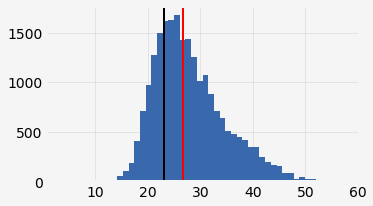

In [14]:
ax = train.sharpness.hist(bins=50)
ax.axvline(x=train.sharpness.median(), color='r');
ax.axvline(x=train.sharpness.quantile(.25), color='k');
print(f"The sharpness threshold {train.sharpness.quantile(.25):.2f}")

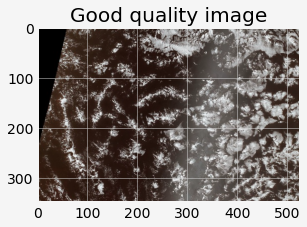

In [15]:
img_id_list = list(train.loc[train.sharpness >= 23.0, 'image_id'])
img = cv2.imread(train_path + img_id_list[0])
plt.title("Good quality image")
plt.imshow(img);

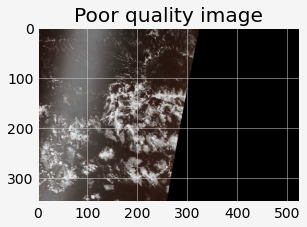

In [16]:
very_bad_img_id_list = list(train.loc[train.sharpness < 13.0, 'image_id'])
img = cv2.imread(train_path + very_bad_img_id_list[1])
plt.title("Poor quality image")
plt.imshow(img);

In [17]:
# read the original documentation
train = pd.read_csv('/content/train.zip')
train.shape

(22184, 2)

In [18]:
train["label"] = train["Image_Label"].apply(lambda x: x.split("_")[1])
train["im_id"] = train["Image_Label"].apply(lambda x: x.split("_")[0])

# only good images are used
train = train.loc[train["im_id"].isin(img_id_list), :]

sub = pd.read_csv(submission_path)
sub["label"] = sub["Image_Label"].apply(lambda x: x.split("_")[1])
sub["im_id"] = sub["Image_Label"].apply(lambda x: x.split("_")[0])

# split data using stratification on the number of mask in the pictures
# Take the first fold for training a model
# For cross-val, we could train on the other folds (but time consuming)
id_mask_count = (
    train.loc[train["EncodedPixels"].isnull() == False, "Image_Label"]
    .apply(lambda x: x.split("_")[0])
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "img_id", "Image_Label": "count"})
)
ids = id_mask_count["img_id"].values
li = [
    [train_index, test_index]
    for train_index, test_index in StratifiedKFold(
        n_splits=N_FOLDS, random_state=SEED, shuffle=True,
    ).split(ids, id_mask_count["count"])
]
train_ids, valid_ids = ids[li[MODEL_NO][0]], ids[li[MODEL_NO][1]]
test_ids = sub["Image_Label"].apply(lambda x: x.split("_")[0]).drop_duplicates().values

print(f"training set   {train_ids[:5]}.. with length {len(train_ids)}")
print(f"validation set {valid_ids[:5]}.. with length {len(valid_ids)}")
print(f"testing set    {test_ids[:5]}.. with length {len(test_ids)}")

training set   ['0011165.jpg' '006c5a6.jpg' '008233e.jpg' '008a5ff.jpg' '0091591.jpg'].. with length 3326
validation set ['003994e.jpg' '009e2f3.jpg' '0146ef3.jpg' '0153a8b.jpg' '0225687.jpg'].. with length 832
testing set    ['002f507.jpg' '0035ae9.jpg' '0038327.jpg' '004f759.jpg' '005ba08.jpg'].. with length 3698


## Define the data-loader
The data-loaders will push the images to the GPU while augmenting the data (new images) by performing transformations (rotation, crop, etc.)


In [19]:
# define dataset and dataloader
num_workers = 0 # to avoid any parallelization error, set this to 0
bs = 8
train_dataset = CloudDataset(
    df=train,
    datatype="train",
    img_ids=train_ids,
    img_dir=folder_path,
    subfolder = "train_images_525/",
    mask_subfolder = "train_masks_525/",
    transforms=get_training_augmentation(),
)
valid_dataset = CloudDataset(
    df=train,
    datatype="valid",
    img_ids=valid_ids,
    img_dir=folder_path,
    subfolder = "train_images_525/",
    mask_subfolder = "train_masks_525/",
    transforms=get_validation_augmentation(),
)

train_loader = DataLoader(
    train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers
)
valid_loader = DataLoader(
    valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers
)

## Model definition and set up

In this first attempt, the native (vanilla) UNet architecture is used. Then I fine tuned a pre-trained UNet.

In [20]:
# # one channel because images converted to grayscale
# model = UNet(n_channels=3, n_classes=4).float()
# if train_on_gpu:
#     model.cuda()

In [21]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

# define the architecture
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)

# get the preprocessing functions
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

if train_on_gpu:
    model.cuda()

In [22]:
model # print Model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Model set up
We define the 
* loss function (weighted average of thebinary cross-entropy and the dice coefficient)
* the optimizer: rectified Adam (less sensitive to the learning rate)
* update of the learning rate (for finer optimization, but takes longer)
* learning rate updater

In [23]:
criterion = BCEDiceLoss(activation=None) #DiceBCELoss()
optimizer = RAdam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

## Training loop
The usual training loop, without fancy add-ons

 - push to gpu
 - forward pass : compute the predicted outputs
 - compute the loss
 - backward propagation : compute the gradient of the loss w.r.t the models parameters
 - perform a step of parameters optimization

Evalutate on the validation set and iterate for several cycles (aka epochs). Save the best model. 

In [24]:
# number of epochs to train the model
n_epochs = 40
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
epoch_bar = tq(range(1, n_epochs+1))
for epoch in epoch_bar:
    epoch_bar.set_description(f"Epoch {epoch:<4}")
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_loader, postfix={"train_loss":0.0})
    batch_nbr = 0
    for data, target in bar:
        bar.set_description(f"Training on batch {batch_nbr:<4}")
        batch_nbr += 1
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0}, desc='validation')
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print(f'Epoch: {epoch}  Training Loss: {train_loss:.6f}  Validation Loss: {valid_loss:.6f} Dice Score: {dice_score:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), folder_path + 'pretrained_unet.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 1  Training Loss: 1.002433  Validation Loss: 1.016250 Dice Score: 0.440753
Validation loss decreased (inf --> 1.016250).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 2  Training Loss: 0.934055  Validation Loss: 1.138979 Dice Score: 0.405199


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 3  Training Loss: 0.917595  Validation Loss: 1.437269 Dice Score: 0.344142


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 4  Training Loss: 0.906360  Validation Loss: 1.024981 Dice Score: 0.446544


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 5  Training Loss: 0.866330  Validation Loss: 0.873076 Dice Score: 0.484418
Validation loss decreased (1.016250 --> 0.873076).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 6  Training Loss: 0.846691  Validation Loss: 0.835761 Dice Score: 0.511407
Validation loss decreased (0.873076 --> 0.835761).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 7  Training Loss: 0.843260  Validation Loss: 0.827851 Dice Score: 0.508584
Validation loss decreased (0.835761 --> 0.827851).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 8  Training Loss: 0.843333  Validation Loss: 0.857339 Dice Score: 0.504731


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 9  Training Loss: 0.844069  Validation Loss: 0.856589 Dice Score: 0.493331


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 10  Training Loss: 0.833003  Validation Loss: 0.797315 Dice Score: 0.522671
Validation loss decreased (0.827851 --> 0.797315).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 11  Training Loss: 0.832527  Validation Loss: 0.856757 Dice Score: 0.496149


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 12  Training Loss: 0.830177  Validation Loss: 0.826231 Dice Score: 0.507903


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 13  Training Loss: 0.822205  Validation Loss: 0.796931 Dice Score: 0.524974
Validation loss decreased (0.797315 --> 0.796931).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 14  Training Loss: 0.818628  Validation Loss: 0.812715 Dice Score: 0.515212


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 15  Training Loss: 0.815260  Validation Loss: 0.834717 Dice Score: 0.510391


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 16  Training Loss: 0.815209  Validation Loss: 0.858979 Dice Score: 0.491942


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 17  Training Loss: 0.793724  Validation Loss: 0.770709 Dice Score: 0.537995
Validation loss decreased (0.796931 --> 0.770709).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 18  Training Loss: 0.780676  Validation Loss: 0.767931 Dice Score: 0.541750
Validation loss decreased (0.770709 --> 0.767931).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 19  Training Loss: 0.773062  Validation Loss: 0.759237 Dice Score: 0.546609
Validation loss decreased (0.767931 --> 0.759237).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 20  Training Loss: 0.769039  Validation Loss: 0.766034 Dice Score: 0.535684


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 21  Training Loss: 0.771541  Validation Loss: 0.779669 Dice Score: 0.535943


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 22  Training Loss: 0.770737  Validation Loss: 0.765456 Dice Score: 0.540392


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 23  Training Loss: 0.762635  Validation Loss: 0.754357 Dice Score: 0.548271
Validation loss decreased (0.759237 --> 0.754357).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 24  Training Loss: 0.755090  Validation Loss: 0.754851 Dice Score: 0.545888


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 25  Training Loss: 0.756901  Validation Loss: 0.754295 Dice Score: 0.546344
Validation loss decreased (0.754357 --> 0.754295).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 26  Training Loss: 0.753055  Validation Loss: 0.752133 Dice Score: 0.548044
Validation loss decreased (0.754295 --> 0.752133).  Saving model ...


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 27  Training Loss: 0.752566  Validation Loss: 0.754359 Dice Score: 0.547773


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 28  Training Loss: 0.753818  Validation Loss: 0.755351 Dice Score: 0.542822


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 29  Training Loss: 0.749818  Validation Loss: 0.757900 Dice Score: 0.543255


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 30  Training Loss: 0.749490  Validation Loss: 0.754834 Dice Score: 0.547068


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 31  Training Loss: 0.747354  Validation Loss: 0.753152 Dice Score: 0.547191


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 32  Training Loss: 0.748648  Validation Loss: 0.754587 Dice Score: 0.546754


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 33  Training Loss: 0.754074  Validation Loss: 0.755256 Dice Score: 0.547744


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 34  Training Loss: 0.750553  Validation Loss: 0.753430 Dice Score: 0.547556


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 35  Training Loss: 0.742169  Validation Loss: 0.754957 Dice Score: 0.545326


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 36  Training Loss: 0.750880  Validation Loss: 0.756974 Dice Score: 0.546008


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 37  Training Loss: 0.745816  Validation Loss: 0.754603 Dice Score: 0.547424


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 38  Training Loss: 0.753373  Validation Loss: 0.754319 Dice Score: 0.548531


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 39  Training Loss: 0.744857  Validation Loss: 0.753792 Dice Score: 0.549280


  0%|          | 0/416 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/104 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 40  Training Loss: 0.750374  Validation Loss: 0.758236 Dice Score: 0.548186


In [25]:
# scaler = torch.cuda.amp.GradScaler()
# # number of epochs to train the model
# n_epochs = 32
# train_loss_list = []
# valid_loss_list = []
# dice_score_list = []
# lr_rate_list = []
# valid_loss_min = np.Inf # track change in validation loss
# epoch_bar = tq(range(1, n_epochs+1))
# for epoch in epoch_bar:
#     epoch_bar.set_description(f"Epoch {epoch:<4}")
#     # keep track of training and validation loss
#     train_loss = 0.0
#     valid_loss = 0.0
#     dice_score = 0.0
#     ###################
#     # train the model #
#     ###################
#     model.train()
#     bar = tq(train_loader, postfix={"train_loss":0.0})
#     batch_nbr = 0
#     for data, target in bar:
#         bar.set_description(f"Training on batch {batch_nbr:<4}")
#         batch_nbr += 1
#         # move tensors to GPU if CUDA is available
#         if train_on_gpu:
#             data, target = data.cuda(), target.cuda()
#         # clear the gradients of all optimized variables
#         optimizer.zero_grad()
#         # Casts operations to mixed precision
#         with torch.cuda.amp.autocast():
#           pred = model(data)
#           # calculate the batch loss
#           loss = criterion(pred, target)
#         # Scales the loss, and calls backward()
#         # to create scaled gradients
#         scaler.scale(loss).backward()

#         # Unscales gradients and calls
#         # or skips optimizer.step()
#         scaler.step(optimizer)
#         # update training loss
#         train_loss += loss.item()*data.size(0)
#         # Updates the scale for next iteration
#         scaler.update()
#         bar.set_postfix(ordered_dict={"train_loss":loss.item()})
#     ######################    
#     # validate the model #
#     ######################
#     model.eval()
#     del data, target
#     with torch.no_grad():
#         bar = tq(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0}, desc='validation')
#         for data, target in bar:
#             # move tensors to GPU if CUDA is available
#             if train_on_gpu:
#                 data, target = data.cuda(), target.cuda()
#             # forward pass: compute predicted outputs by passing inputs to the model
#             output = model(data)
#             # calculate the batch loss
#             loss = criterion(output, target)
#             # update average validation loss 
#             valid_loss += loss.item()*data.size(0)
#             dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
#             dice_score +=  dice_cof * data.size(0)
#             bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
#     # calculate average losses
#     train_loss = train_loss/len(train_loader.dataset)
#     valid_loss = valid_loss/len(valid_loader.dataset)
#     dice_score = dice_score/len(valid_loader.dataset)
#     train_loss_list.append(train_loss)
#     valid_loss_list.append(valid_loss)
#     dice_score_list.append(dice_score)
#     lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
#     # print training/validation statistics 
#     print(f'Epoch: {epoch}  Training Loss: {train_loss:.6f}  Validation Loss: {valid_loss:.6f} Dice Score: {dice_score:.6f}')
    
#     # save model if validation loss has decreased
#     if valid_loss <= valid_loss_min:
#         print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), folder_path + 'vanilla_unet_amp.pt')
#         valid_loss_min = valid_loss
    
#     scheduler.step(valid_loss)

## Ploting Metrics

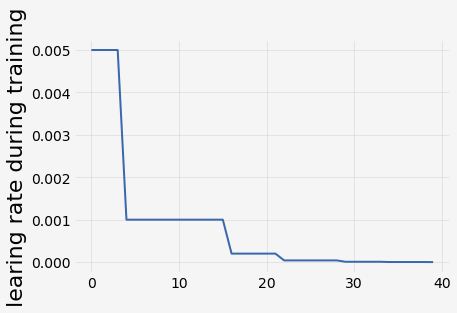

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot([i[0] for i in lr_rate_list])
ax.set_ylabel('learing rate during training', fontsize=22)
fig.savefig("learning_rate.png")

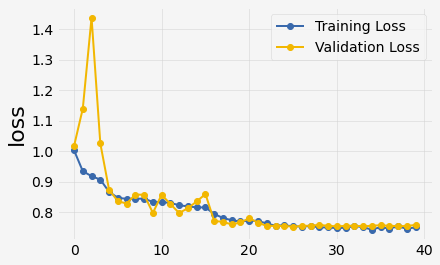

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(train_loss_list,  marker='o', label="Training Loss")
ax.plot(valid_loss_list,  marker='o', label="Validation Loss")
ax.set_ylabel('loss', fontsize=22)
ax.legend()
fig.savefig("loss.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


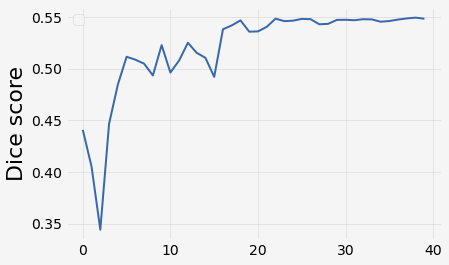

In [28]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(dice_score_list)
ax.set_ylabel('Dice score', fontsize=22)
ax.legend()
fig.savefig("dice_score.png")

In [29]:
# load best model
model.load_state_dict(torch.load(folder_path + 'pretrained_unet.pt'))
model.eval();

In [30]:
valid_masks = []
count = 0
tr = min(len(valid_ids)*4, 2000)
probabilities = np.zeros((tr, 350, 525), dtype = np.float32)
valid_bar = tq(valid_loader)
val_batch_nbr = 0
for data, target in valid_bar:
    valid_bar.set_description(f"Validating on batch nbr {val_batch_nbr:4}")
    val_batch_nbr += 1
    if train_on_gpu:
        data = data.cuda()
    target = target.cpu().detach().numpy()
    outpu = model(data).cpu().detach().numpy()
    for p in range(data.shape[0]):
        output, mask = outpu[p], target[p]
        for m in mask:
            valid_masks.append(resize(m))
        for probability in output:
            probabilities[count, :, :] = resize(probability)
            count += 1
        if count >= tr - 1:
            break
    if count >= tr - 1:
        break

  0%|          | 0/104 [00:00<?, ?it/s]

In [31]:
valid_masks = []
count = 0
tr = min(len(valid_ids)*4, 2000)
probabilities = np.zeros((tr, 350, 525), dtype = np.float32)
val_batch_nbr = 0
for data, target in valid_bar:
    valid_bar.set_description(f"Validating on batch nbr {val_batch_nbr:4}")
    val_batch_nbr += 1
    if train_on_gpu:
        data = data.cuda()
    target = target.cpu().detach().numpy()
    outpu = model(data).cpu().detach().numpy()
    for p in range(data.shape[0]):
        output, mask = outpu[p], target[p]
        for m in mask:
            valid_masks.append(resize(m))
        for probability in output:
            probabilities[count, :, :] = resize(probability)
            count += 1
        if count >= tr - 1:
            break
    if count >= tr - 1:
        break

## Grid Search for best Threshold
Try out several threshold for the probability, compute the loss and choose the best value (validation set)

In [32]:
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5):
        t /= 100
        for ms in [0, 100, 1200, 5000, 10000, 30000]:
            masks, d = [], []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(probability, t, ms)
                masks.append(predict)
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))
            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    class_params[class_id] = (best_threshold, best_size)

0
    threshold   size      dice
35       0.25  30000  0.606701
47       0.35  30000  0.606065
41       0.30  30000  0.603740
53       0.40  30000  0.601355
65       0.50  30000  0.600941
1
    threshold   size      dice
70       0.55  10000  0.767596
64       0.50  10000  0.766290
58       0.45  10000  0.766245
69       0.55   5000  0.762509
75       0.60   5000  0.762032
2
    threshold   size      dice
52       0.40  10000  0.580863
35       0.25  30000  0.579278
82       0.65  10000  0.578964
70       0.55  10000  0.578673
76       0.60  10000  0.578179
3
    threshold   size      dice
64       0.50  10000  0.596793
70       0.55  10000  0.594580
58       0.45  10000  0.593399
76       0.60  10000  0.593259
82       0.65  10000  0.592230


In [33]:
del masks
del valid_masks
del probabilities
gc.collect()

12036

In [34]:
attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
print(class_params)

{0: (0.25, 30000), 1: (0.55, 10000), 2: (0.4, 10000), 3: (0.5, 10000)}


In [35]:
attempts_df.groupby(['threshold'])['dice'].max()

threshold
0.00    0.277845
0.05    0.512065
0.10    0.551329
0.15    0.565519
0.20    0.567820
0.25    0.569610
0.30    0.579181
0.35    0.587301
0.40    0.591556
0.45    0.593399
0.50    0.596793
0.55    0.594580
0.60    0.593259
0.65    0.592230
0.70    0.588126
0.75    0.577646
0.80    0.557478
0.85    0.527803
0.90    0.474418
0.95    0.396235
Name: dice, dtype: float64

In [36]:
attempts_df.groupby(['size'])['dice'].max()

size
0        0.553599
100      0.555605
1200     0.566936
5000     0.587693
10000    0.596793
30000    0.567820
Name: dice, dtype: float64

In [37]:
attempts_df = attempts_df.sort_values('dice', ascending=False)
attempts_df.head(10)

threshold   size      dice
64       0.50  10000  0.596793
70       0.55  10000  0.594580
58       0.45  10000  0.593399
76       0.60  10000  0.593259
82       0.65  10000  0.592230
52       0.40  10000  0.591556
88       0.70  10000  0.588126
87       0.70   5000  0.587693
46       0.35  10000  0.587301
81       0.65   5000  0.586031

In [38]:
attempts_df.to_csv("grid_search_thres.csv")

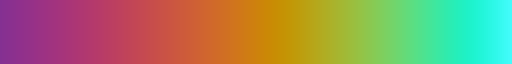

In [39]:
# sc_map = sc.ScicoQualitative(cmap='colorblind')
# sc_cmap = sc_map.get_mpl_color_map()
# mpl.cm.register_cmap("sc_cb", sc_cmap)
sc_cmap

In [40]:
attempts_df = pd.read_csv('grid_search_thres.csv', index_col=0)
attempts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 64 to 0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   threshold  120 non-null    float64
 1   size       120 non-null    int64  
 2   dice       120 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.8 KB


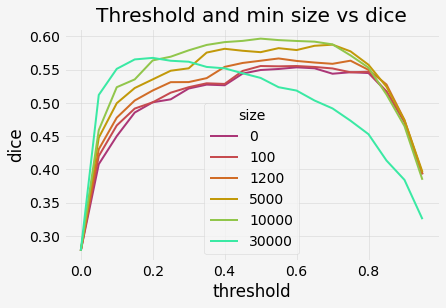

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
attempts_df['size'] = attempts_df['size'].astype("category")
ax = sns.lineplot(x='threshold', 
                   y='dice',
                   data=attempts_df, 
                   hue='size', 
                   palette='sc_tropical', 
                   ax=ax)
ax.set_title('Threshold and min size vs dice');
fig.savefig("gridsearch_thres.png")

In [42]:
best_threshold = attempts_df['threshold'].values[0]
best_size = attempts_df['size'].values[0]

## Predictions visualization
Qualitative visualization of the prediction: original image and mask, probabilities, thresholded probabilities and the convex hull of the detected regions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

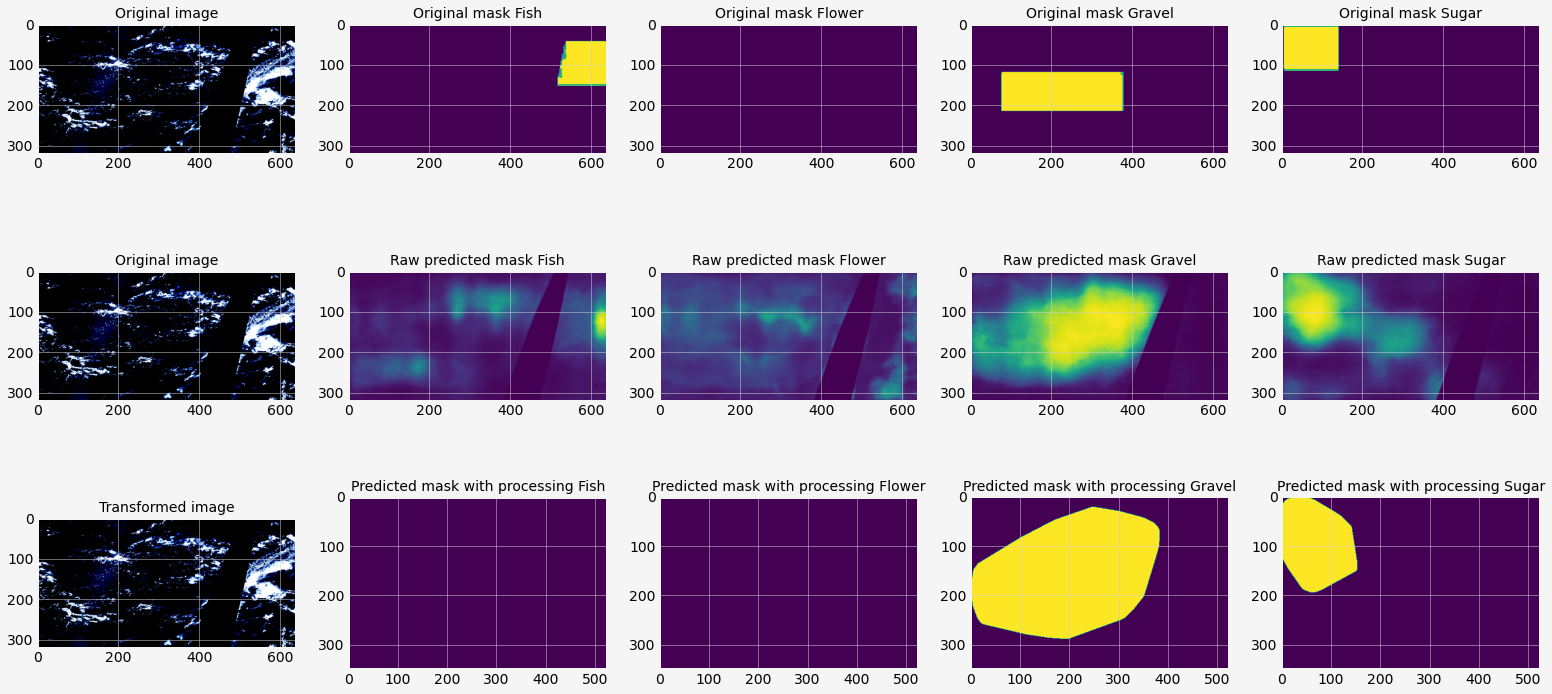

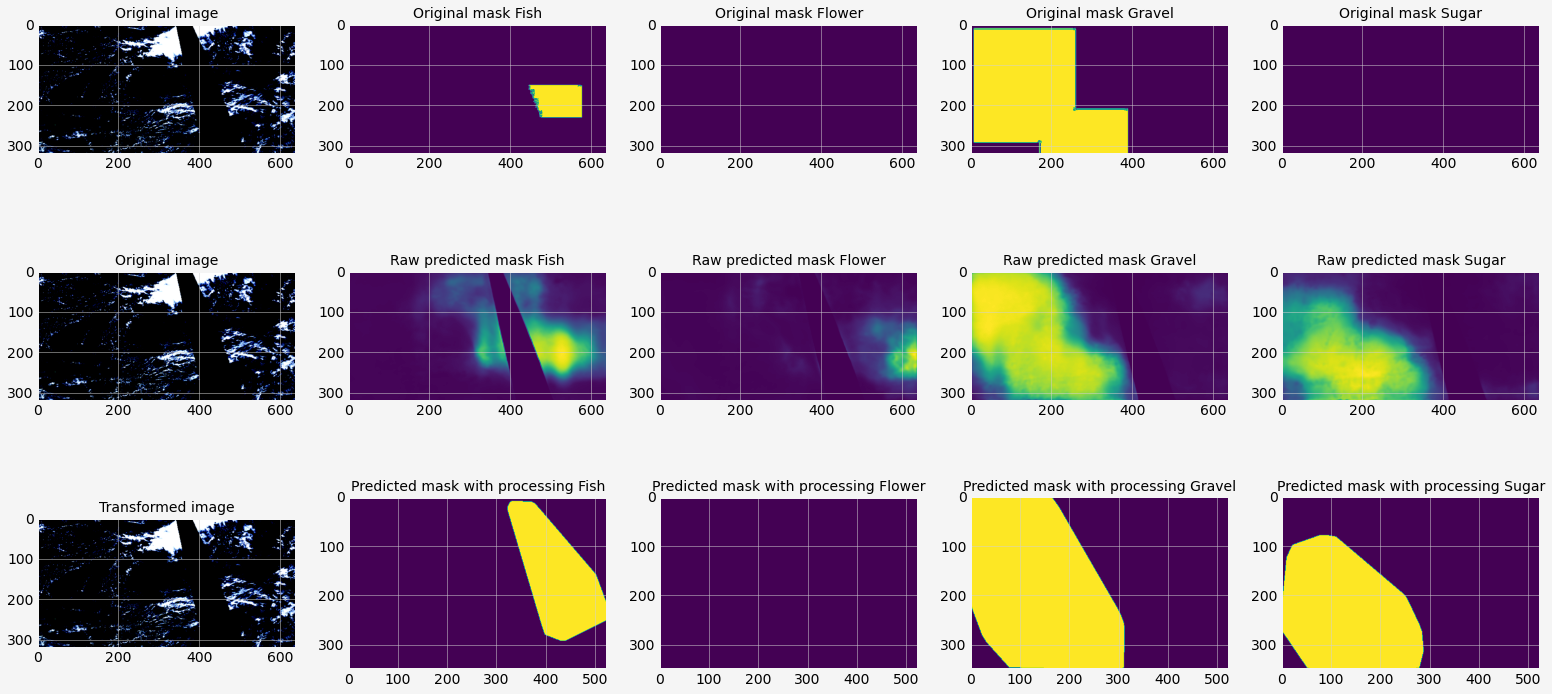

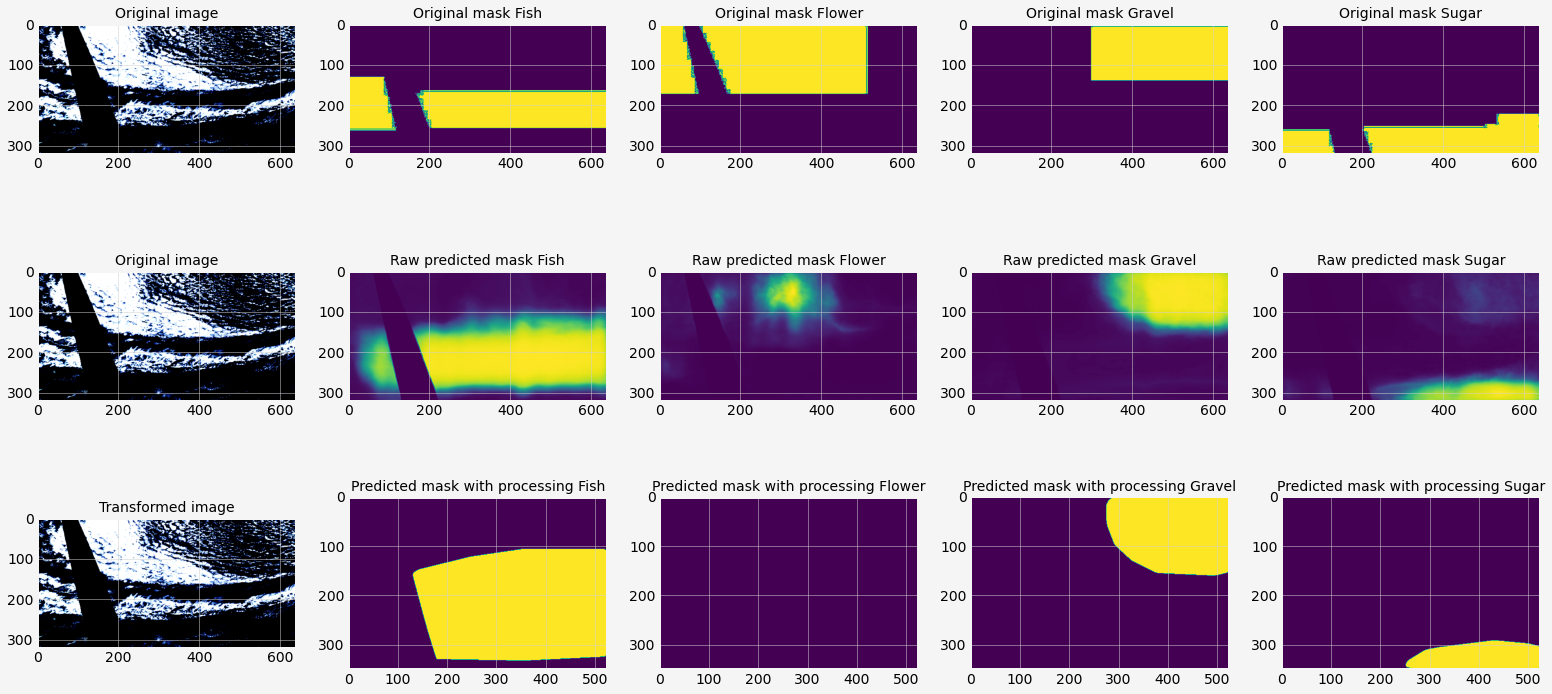

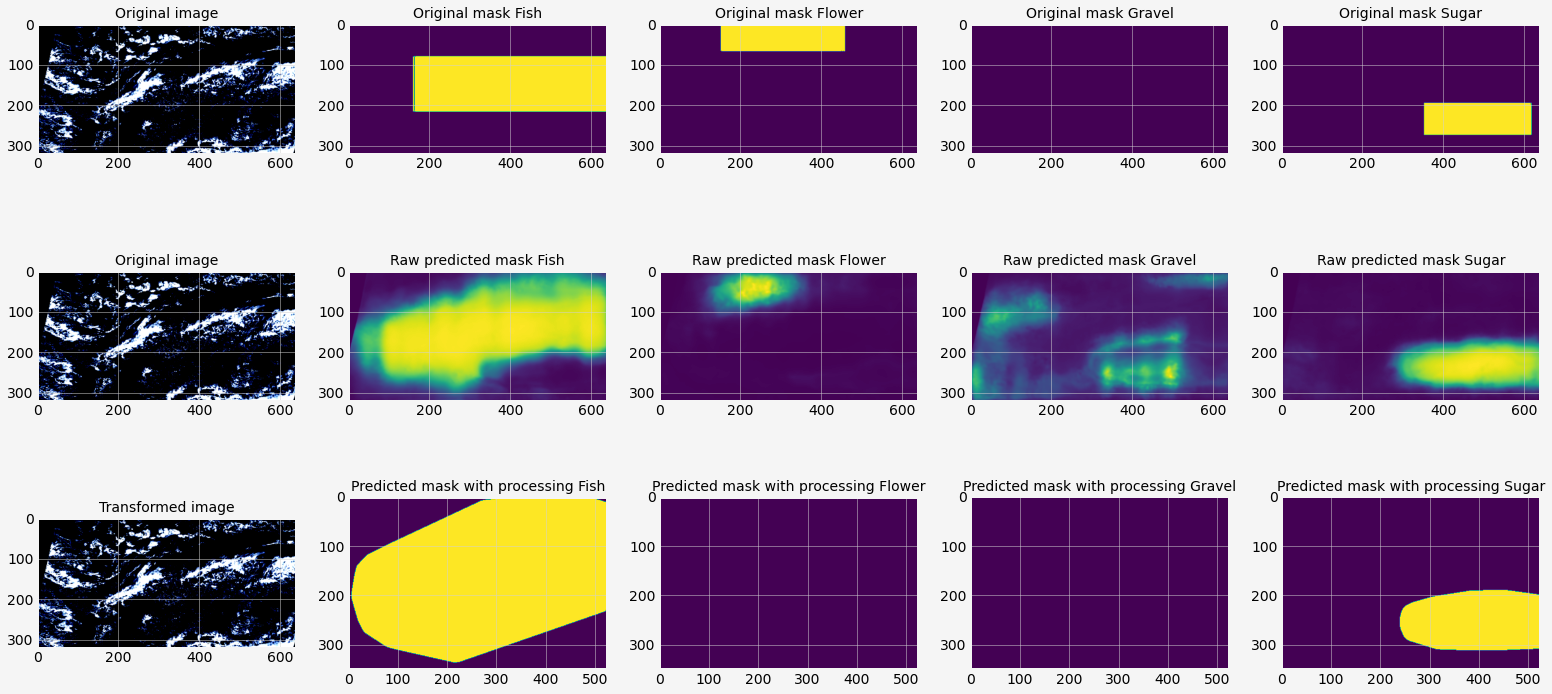

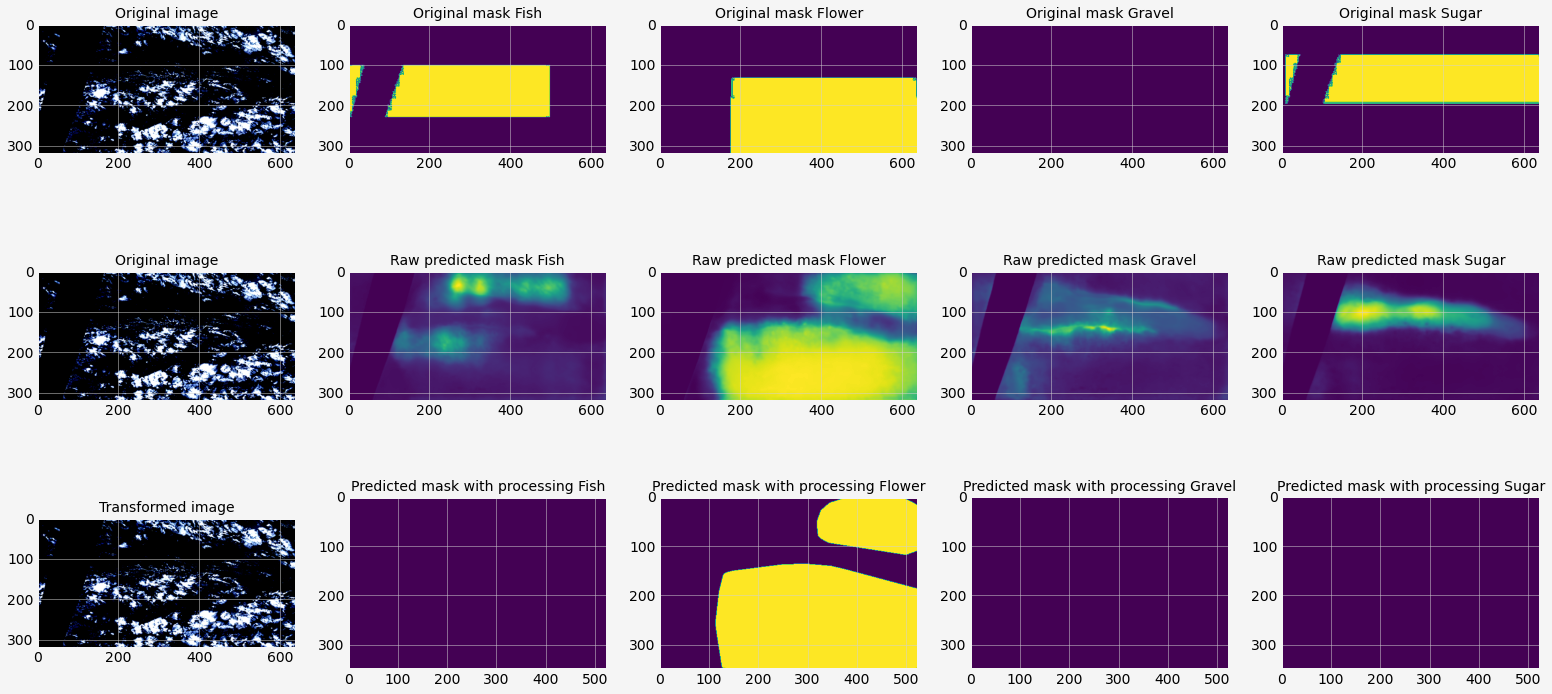

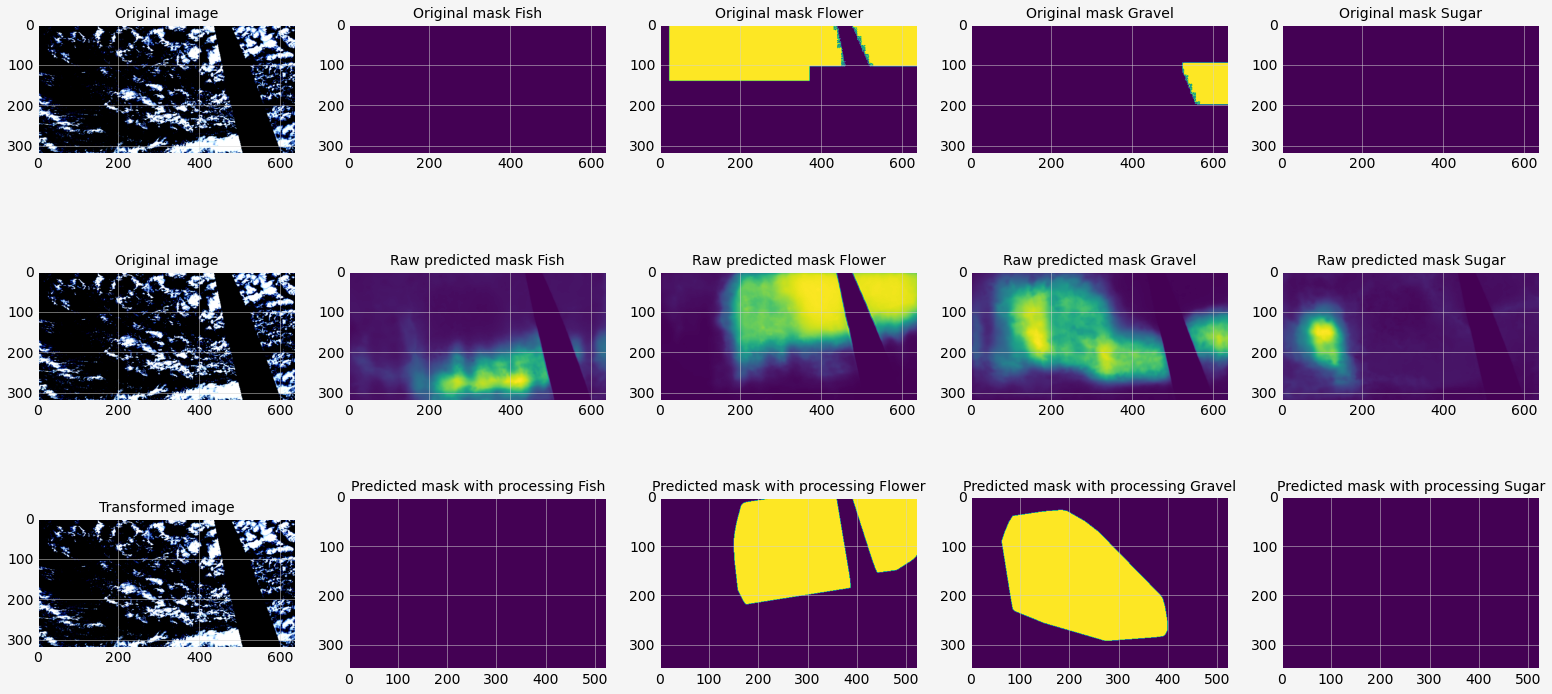

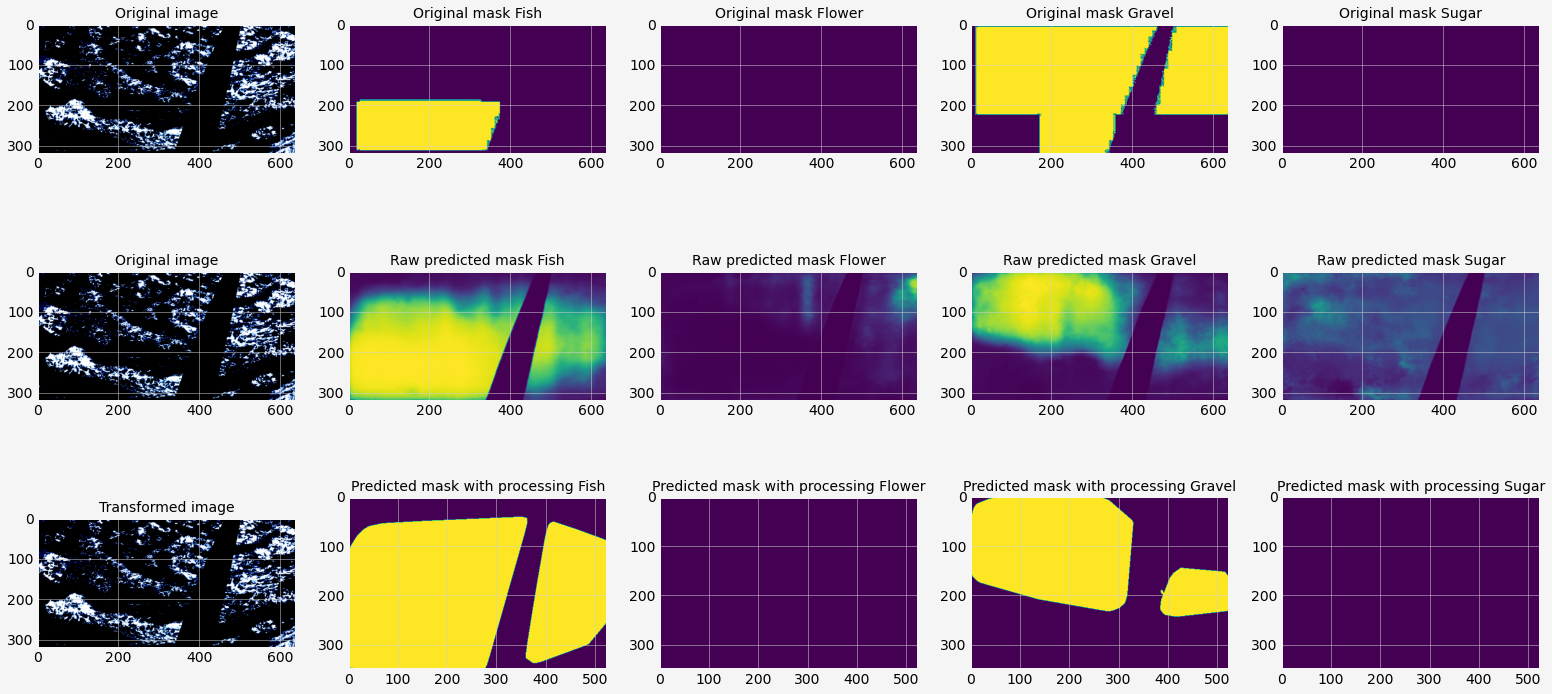

In [43]:
for i, (data, target) in enumerate(valid_loader):
    if train_on_gpu:
        data = data.cuda()
    output = ((model(data))[0]).cpu().detach().numpy()
    image  = data[0].cpu().detach().numpy()
    mask   = target[0].cpu().detach().numpy()
    output = output.transpose(1 ,2, 0)
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = np.zeros((350, 525, 4))
    for j in range(4):
        probability = resize(output[:, :, j])
        pr_mask[:, :, j], _ = post_process(probability,
                                           class_params[j][0],
                                           class_params[j][1])
    visualize_with_raw(image=image_vis, mask=pr_mask,
                      original_image=image_vis, original_mask=mask,
                      raw_image=image_vis, raw_mask=output)
    plt.savefig("pred_with_raw_"+str(i)+".png")
    if i >= 6:
        break

In [44]:
torch.cuda.empty_cache()
gc.collect()

268612

In [45]:
test_dataset = CloudDataset(df=sub,
                            datatype='test', 
                            img_ids=test_ids,
                            img_dir=folder_path,
                            subfolder = "test_images_525/",
                            mask_subfolder = "train_masks_525/",
                            transforms=get_validation_augmentation())
test_loader = DataLoader(test_dataset, 
                         batch_size=4,
                         shuffle=False, 
                         num_workers=2)

In [46]:
del train_dataset, train_loader
del valid_dataset, valid_loader
gc.collect()

100

## Compute scores on the test set

In [47]:
subm = pd.read_csv(submission_path)
pathlist = [test_path + i.split("_")[0] for i in subm['Image_Label']]

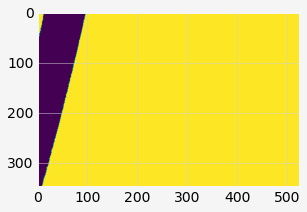

In [48]:
def get_black_mask(image_path):
    img = cv2.imread(image_path) 
    img = cv2.resize(img, dsize=tuple((525,350)), interpolation=cv2.INTER_LINEAR)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 0], np.uint8)
    upper = np.array([180, 255, 10], np.uint8)
    return (~ (cv2.inRange(hsv, lower, upper) > 250)).astype(int)

plt.imshow(get_black_mask(pathlist[120]))
plt.show();

In [49]:
encoded_pixels = []
image_id = 0
cou = 0
np_saved = 0
for data, target in tq(test_loader):
    if train_on_gpu:
        data = data.cuda()
    output = model(data)
    del data
    for i, batch in enumerate(output):
        for probability in batch:
            probability = resize(probability.cpu().detach().numpy())
            predict, num_predict = post_process(probability,
                                                class_params[image_id % 4][0],
                                                class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                black_mask = get_black_mask(pathlist[cou])
                np_saved += np.sum(predict)
                predict = np.multiply(predict, black_mask)
                np_saved -= np.sum(predict)
                r = mask_to_rle(predict)
                encoded_pixels.append(r)
            cou += 1
            image_id += 1

print(f"number of pixel saved {np_saved}")

  0%|          | 0/925 [00:00<?, ?it/s]

number of pixel saved 919187.0


In [50]:
sub['EncodedPixels'] = encoded_pixels
sub.to_csv('unet_pretrained_pred_test.csv', columns=['Image_Label', 'EncodedPixels'], index=False)